# Text Mining su corpus dataspace

Notebook per analizzare un corpus di paper (file `.txt`) relativi ai data space (Smart4nce, Manufacturing-X, ecc.).
Obiettivi:
- Caricare e ispezionare il corpus
- Creare una rappresentazione Bag-of-Words / TF-IDF
- Individuare i termini più rilevanti a livello globale e per documento
- Estrarre alcuni topic (LDA) per capire i temi principali


In [1]:
pip install pandas scikit-learn nltk matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import glob

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import matplotlib.pyplot as plt

# Impostazioni grafiche base
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# Mostra tutte le colonne nei DataFrame
pd.set_option("display.max_colwidth", 200)

## 1. Caricamento del corpus

In questa sezione:
- Definiamo il percorso della cartella che contiene i file `.txt`
- Carichiamo ogni file come un documento
- Creiamo un DataFrame con nome file e testo

In [4]:
# 🔁 MODIFICA QUI: percorso della cartella con i .txt
FOLDER = "/Users/antonellamosca/Desktop/MANUFACTURING"  

# Trova tutti i .txt nella cartella
files = glob.glob(os.path.join(FOLDER, "*.txt"))
print(f"Numero di documenti trovati: {len(files)}")

# Legge i file
texts = []
filenames = []

for path in files:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        texts.append(f.read())
        filenames.append(os.path.basename(path))

corpus = pd.DataFrame({
    "filename": filenames,
    "text": texts
})

corpus.head()

Numero di documenti trovati: 0


,filename,text


## 2. Esplorazione iniziale del corpus

Calcoliamo:
- lunghezza dei documenti in caratteri
- (eventualmente) una statistica descrittiva


In [5]:
corpus["n_chars"] = corpus["text"].str.len()

corpus[["filename", "n_chars"]].sort_values("n_chars", ascending=False).head(10)


AttributeError: Can only use .str accessor with string values!

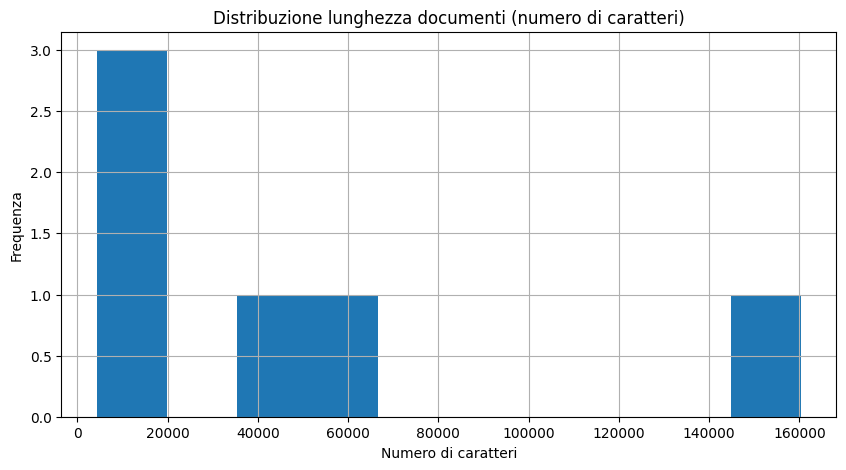

In [14]:
corpus["n_chars"].hist(bins=10)
plt.title("Distribuzione lunghezza documenti (numero di caratteri)")
plt.xlabel("Numero di caratteri")
plt.ylabel("Frequenza")
plt.show()

## 3. Rappresentazione vettoriale (TF-IDF)

Utilizziamo `TfidfVectorizer` di scikit-learn:
- rimozione stopword inglesi
- ignoriamo termini troppo frequenti (`max_df`)
- ignoriamo termini rarissimi (`min_df`)
- consideriamo uni-grammi e bi-grammi

In [34]:
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

# 1) Stopword di dominio (solo token singoli)
domain_stopwords = {
    "study", "figure", "fig", "basic", "used", "new",
    "work", "development", "case", "example", "results",
    "approach", "paper", "corpus", "stemming", "access",
    "spaces", "data",        # meglio così che "data spaces"
    "web", "user"
}

# 2) Stopword aggiuntive sporche / token strani
extra_stop = {
    "ds", "sp", "yo", "ow", "vo", "ve", "fi", "ea", "ex",
    # aggiungi qui tutte le altre che hai visto nei topic-spazzatura
}

# 3) Unione -> CONVERSIONE A LISTA (qui era il problema)
custom_stopwords = list(
    ENGLISH_STOP_WORDS.union(domain_stopwords).union(extra_stop)
)

vectorizer = CountVectorizer(
    stop_words=custom_stopwords,      # ora è una list, non frozenset
    lowercase=True,
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",  # parole da 2 lettere in su
    min_df=2,        # almeno in 2 documenti
    max_df=0.8,      # presente in max 80% dei documenti
    ngram_range=(1, 2),
    vocabulary=None
)

# 5) Fit sul testo (se corpus è un DataFrame con colonna 'text')
X_counts = vectorizer.fit_transform(corpus["text"].fillna("").astype(str))

feature_names = vectorizer.get_feature_names_out()
print("Shape matrice di conteggi:", X_counts.shape)
print("Prime 20 feature:", feature_names[:20])



Shape matrice di conteggi: (6, 2050)
Prime 20 feature: ['aas' 'aas metamodel' 'aas opc' 'aas repository' 'aas submodels'
 'ability' 'accelerate' 'acceptance' 'accessibility' 'accessible'
 'accordance' 'according' 'accordingly' 'account' 'accounting' 'accurate'
 'achieve' 'achieve interoperability' 'achieved' 'achieving']


## 4. Termini più rilevanti nel corpus (globalmente)

Sommiamo i pesi TF-IDF lungo tutti i documenti per ottenere l'importanza media
di ciascun termine sul corpus.

In [35]:
tfidf_sum = X_counts.sum(axis=0)
tfidf_sum = np.asarray(tfidf_sum).ravel()

terms_scores = pd.DataFrame({
    "term": feature_names,
    "score": tfidf_sum
}).sort_values("score", ascending=False)

terms_scores.head(60)



,term,score
1483,projects,106
0,aas,94
1296,opc,86
1953,ua,74
1163,manufacturing space,73
936,industrie,69
1298,opc ua,68
1773,specific,67
122,asset,66
723,flagship,65


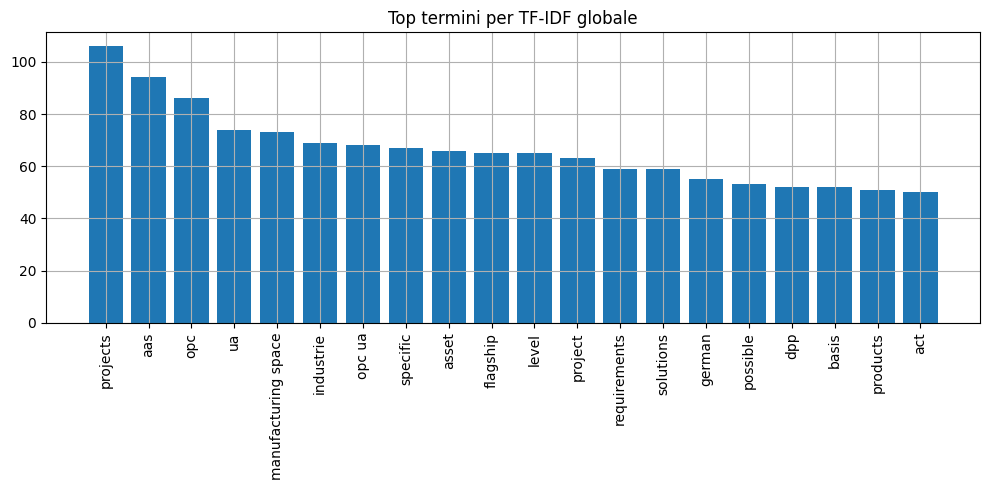

In [36]:
top_n = 20
top_terms = terms_scores.head(top_n)

plt.bar(range(top_n), top_terms["score"])
plt.xticks(range(top_n), top_terms["term"], rotation=90)
plt.title("Top termini per TF-IDF globale")
plt.tight_layout()
plt.show()


## 5. Termini principali per documento

Definiamo una funzione che, dato l'indice di un documento, restituisce i suoi
termini con TF-IDF più alto.

In [37]:
def top_terms_for_doc(doc_id, top_n=15):
    """Restituisce un DataFrame con i top termini del documento `doc_id`."""
    row = X_counts[doc_id].toarray().ravel()
    idx = row.argsort()[::-1][:top_n]
    return pd.DataFrame({
        "term": feature_names[idx],
        "score": row[idx]
    })

#CAMBIANDO VALORE A DOC_ID SI SCORRONO I PAPER
doc_id = 0
print("Documento:", corpus.loc[doc_id, "filename"])
top_terms_for_doc(doc_id, top_n=20)

Documento: P119e_BASF_Cofinity_X.txt


,term,score
0,cofinity,23
1,value chain,12
2,customers,8
3,automotive value,6
4,partner,5
5,group,4
6,marketplace,4
7,solutions,4
8,adoption,4
9,materials,4


## 6. Topic modeling con LDA

Applichiamo un modello LDA (Latent Dirichlet Allocation) alla matrice TF-IDF
per estrarre alcuni "topic" latenti.

In [38]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 3  # prova con pochi topic all'inizio

lda = LatentDirichletAllocation(
    n_components=n_topics,
    learning_method="batch",
    random_state=42
)

lda.fit(X_counts)

,n_components,3
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [39]:
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n### Topic {topic_idx}")
        top_idx = topic.argsort()[::-1][:n_top_words]
        print(", ".join(feature_names[i] for i in top_idx))

print_topics(lda, feature_names, n_top_words=10)




### Topic 0
dpp, circular, circular economy, battery, passport, products, digital product, value chain, collaborative ecosystem, life

### Topic 1
projects, manufacturing space, aas, flagship, industrie, level, project, specific, asset, german

### Topic 2
opc, ua, opc ua, cofinity, aas, cloud, standardized, value chain, architecture, foundation


In [40]:
doc_topic_dist = lda.transform(X_counts)
corpus["main_topic"] = doc_topic_dist.argmax(axis=1)
corpus[["filename", "main_topic"]].head(20)



,filename,main_topic
0,P119e_BASF_Cofinity_X.txt,2
1,DPP_Catena_X_FINAL.txt,0
2,Manufacturing_X_long.txt,1
3,OPCF_Catena_X_Architecture_Whitepaper_v1_0.txt,2
4,Manufacturing_X_Data_Space_Study_ZVEI_VDMA_Fraunhofer.txt,1
5,Manufacturing_X.txt,2


### 6.1 Visualizzazione dei topic

Rappresentiamo graficamente, per un topic scelto, i termini con peso più alto
nel modello LDA.

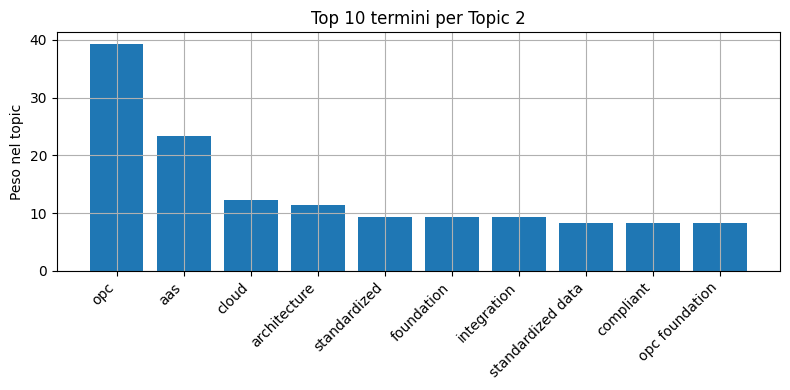

In [27]:
def plot_top_words(model, feature_names, topic_idx, n_top_words=10):
    """Barplot dei top termini per il topic `topic_idx`."""
    topic = model.components_[topic_idx]
    top_idx = topic.argsort()[::-1][:n_top_words]
    top_terms = feature_names[top_idx]
    top_weights = topic[top_idx]

    plt.figure(figsize=(8, 4))
    plt.bar(range(n_top_words), top_weights)
    plt.xticks(range(n_top_words), top_terms, rotation=45, ha="right")
    plt.title(f"Top {n_top_words} termini per Topic {topic_idx}")
    plt.ylabel("Peso nel topic")
    plt.tight_layout()
    plt.show()

# CAMBIANDO TOPIC_IDX SI SCORRONO I TOPIC
plot_top_words(lda, feature_names, topic_idx=2, n_top_words=10)


In [28]:
doc_topic_dist = lda.transform(X_counts)
corpus["main_topic"] = doc_topic_dist.argmax(axis=1)


### 6.2 Distribuzione dei documenti per topic principale

Osserviamo quanti documenti sono assegnati (come topic dominante) a ciascun topic.


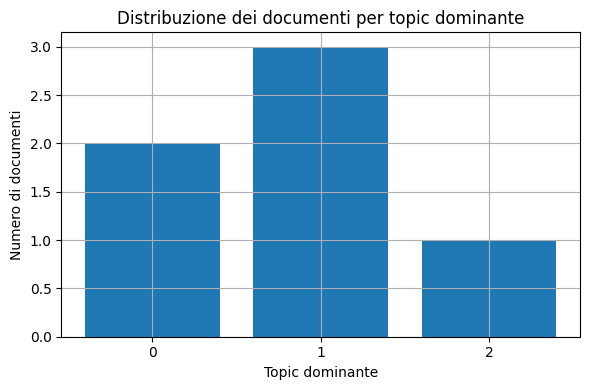

main_topic
0    2
1    3
2    1
Name: count, dtype: int64

In [29]:
topic_counts = corpus["main_topic"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(topic_counts.index, topic_counts.values)
plt.xlabel("Topic dominante")
plt.ylabel("Numero di documenti")
plt.title("Distribuzione dei documenti per topic dominante")
plt.xticks(topic_counts.index)
plt.tight_layout()
plt.show()

topic_counts


## 7. Esportazione risultati

Esportiamo:
- associazione documento-topic
- lista dei termini globali con score TF-IDF

In [34]:
output_folder = os.path.join(FOLDER, "output")
os.makedirs(output_folder, exist_ok=True)

corpus.to_csv(os.path.join(output_folder, "documenti_con_topic.csv"), index=False)
terms_scores.to_csv(os.path.join(output_folder, "termini_tfidf_globali.csv"), index=False)

print("File salvati in:", output_folder)


File salvati in: /Users/danielegiovanardi/Desktop/VOYANT_CORPUS_DATASPACES_DANIELE/output
